<a href="https://colab.research.google.com/github/DanielRoblesBallester/imcr/blob/master/Detector%20de%20Caidas/Fall_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parametros Ajustables

In [ ]:
#Variables Globales para ajustar el entrenamiento de una manera localizada
batch_size = 64 # Tamaño del lote 
epochs = 15 #Numero de iteraciones en el entrenamiento de nuestra red
input_shape = 0
num_classes=2

img_cols, img_rows = 32, 32

#Librerias

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
import cv2
import os as os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle


from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras import models


from scipy import ndimage

#Preparando el DataSet
**Descargamos el conjunto de imagenes a emplear**

Para ello, hemos hecho uso de [direct downloaders](https://sites.google.com/site/gdocs2direct/) para poder importar las imagenes de una manera automatica descargandolas (como si tuvieramos nuestro propio servidor de archivos). Por defecto el enlace de google drive nos da un boton de aviso diciendo que el archivo es muy grande, por lo que para bypasear ese aviso tenemos que añadir la parte de confirm=t

In [ ]:
!rm -rf *
!wget "https://drive.google.com/uc?export=download&id=1fXk_O66UFko8VjaFb_-siGu7yEM37LNC&confirm=t" -O dataSet.tar

--2022-06-01 23:07:00--  https://drive.google.com/uc?export=download&id=1fXk_O66UFko8VjaFb_-siGu7yEM37LNC&confirm=t
Resolving drive.google.com (drive.google.com)... 74.125.195.100, 74.125.195.138, 74.125.195.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-1s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ic1v640n0dkt6irqn24jndkgqncnpoed/1654124775000/03942168396322362906/*/1fXk_O66UFko8VjaFb_-siGu7yEM37LNC?e=download [following]
--2022-06-01 23:07:00--  https://doc-0g-1s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ic1v640n0dkt6irqn24jndkgqncnpoed/1654124775000/03942168396322362906/*/1fXk_O66UFko8VjaFb_-siGu7yEM37LNC?e=download
Resolving doc-0g-1s-docs.googleusercontent.com (doc-0g-1s-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-0g-1s-docs.googleusercontent.com (doc-

In [ ]:
!tar -xf dataSet.tar
!rm -rf dataSet.tar

#Cargando el DataSet

In [ ]:
def load_data():

  name_classes = ['caida','pie']
  caidas, pie= [],[]

  for class_number, class_name in enumerate(name_classes):    # Number of directories
    for filename in glob.glob(f'./{class_name}/*.png'):
      im = image.load_img(filename, target_size=[img_rows, img_cols], color_mode = 'grayscale')
      if class_number==0:
        caidas.append(image.img_to_array(im))
      else:
        pie.append(image.img_to_array(im))

  
  input_shape = (img_rows, img_cols, 1)

  caidas = np.array(caidas).astype(float) / 255 #Normalizamos la muestra de caidas
  pie = np.array(pie).astype(float) / 255 #Normalizamos la muestra de pie

  return caidas,pie, input_shape

In [ ]:
caidas,pie,input_shape=load_data()

In [ ]:
print("Muestra de caidas:", len(caidas))
print("Muestra de pie:", len(pie))

Muestra de caidas: 493
Muestra de pie: 810


#Balanceado
Cuenta el total de elementos de cada clase y balancea ambas muestras.

In [ ]:
def plotPartitions(plot):
  eje_x=[]
  eje_y=[]

  #Caidas
  eje_y.append(plot[0])
  eje_x.append("Conjunto caidas")

  #Pie
  eje_y.append(plot[1])
  eje_x.append("Conjunto pie")

  ## Creamos Gráfica
  plt.bar(eje_x, eje_y)

  ## Leyenda en el eje y
  plt.ylabel('Cantidad de muestras')

  ## Leyenda en el eje x
  plt.xlabel('Conjunto de datos')

  ## Título de Gráfica
  plt.title('Numero de muestras')

  ## Mostramos Gráfica
  plt.show()

  print("Tamaño muestra caidas: ",plot[0])
  print("Tamaño muestra de pie: ",plot[1])

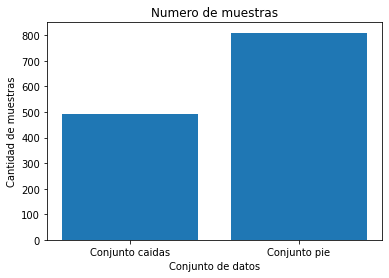

Tamaño muestra caidas:  493
Tamaño muestra de pie:  810


In [ ]:
plot=[len(caidas),len(pie)]
plotPartitions(plot)

In [ ]:
def equilibration(caidas, pie):
  X,y=[],[]
  pie=shuffle(pie)
  for i in range(len(caidas)):
    X.append(pie[i])
    y.append(1)
    X.append(caidas[i])
    y.append(0)
  X,y=shuffle(X,y)
  return np.array(X), np.array(y)

In [ ]:
X,y=equilibration(caidas, pie)
print("Total muestras: ",len(X))

Total muestras:  986


#Definicion de modelo

In [ ]:
def cnn_modelBasic(input_shape_aux):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape_aux))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(64, (5, 5), activation='relu'))                                   #Conforme vamos haciendo mas pequeña la imagen vamos aumentando los filtros ya que no es tan costoso computacionalmente al no tener tantos datos
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())

    model.add(layers.Dense(200, activation='sigmoid'))

    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [ ]:
model = cnn_modelBasic(input_shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=123)

print(f'x_train {X_train.shape} x_test {X_test.shape}')

x_train (739, 32, 32, 1) x_test (247, 32, 32, 1)


In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
  plt.ylim([0,2.5]) ##change
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,2.5]) ##change
  plt.legend()

  plt.show()

#Entrenamiento

In [ ]:
train_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, workers=4,validation_split=0.1, verbose=2)

Epoch 1/15
11/11 - 3s - loss: 0.7278 - accuracy: 0.4767 - val_loss: 0.6951 - val_accuracy: 0.5000 - 3s/epoch - 235ms/step
Epoch 2/15
11/11 - 1s - loss: 0.6891 - accuracy: 0.5083 - val_loss: 0.6810 - val_accuracy: 0.5000 - 1s/epoch - 123ms/step
Epoch 3/15
11/11 - 1s - loss: 0.6600 - accuracy: 0.7083 - val_loss: 0.6290 - val_accuracy: 0.6486 - 1s/epoch - 116ms/step
Epoch 4/15
11/11 - 1s - loss: 0.5722 - accuracy: 0.7789 - val_loss: 0.4970 - val_accuracy: 0.8649 - 1s/epoch - 112ms/step
Epoch 5/15
11/11 - 1s - loss: 0.4046 - accuracy: 0.8812 - val_loss: 0.3423 - val_accuracy: 0.8784 - 1s/epoch - 113ms/step
Epoch 6/15
11/11 - 1s - loss: 0.2636 - accuracy: 0.9203 - val_loss: 0.2695 - val_accuracy: 0.8649 - 1s/epoch - 115ms/step
Epoch 7/15
11/11 - 1s - loss: 0.1810 - accuracy: 0.9414 - val_loss: 0.2603 - val_accuracy: 0.8649 - 1s/epoch - 114ms/step
Epoch 8/15
11/11 - 1s - loss: 0.1840 - accuracy: 0.9398 - val_loss: 0.2406 - val_accuracy: 0.9054 - 1s/epoch - 114ms/step
Epoch 9/15
11/11 - 1s - 

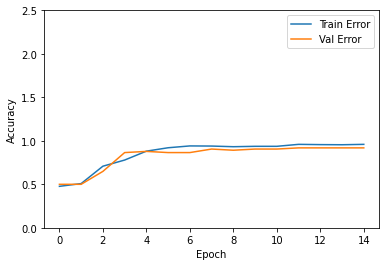

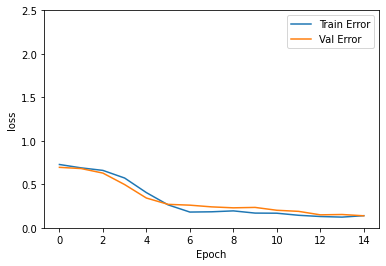

In [ ]:
plot_history(train_history)

#Test de la red entrenada
Se comprueba si se ha realizado un sobreentrenamiento

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=128)

2/2 [==============================] - 0s 45ms/step - loss: 0.1057 - accuracy: 0.9636
